## Pose control, EKF and their implementation
The purpose of thise notebook is to extend the work done in a seperate notebook. With the specifc intention of 

### Extended Kalman Filter: 
This is a toy implementation of an extended kalman filter for systematic rover localization using a collection of sensors. We will simplify the case to 2D. 


### The General form of a kalman filter
#### Predict 
Assuming an unknown control input (might change this later). We use the current state of the rover to predict how it will change into the future. This state estimate will be fused with extra sensor information later. 
State estimate:
$$
\varkappa_{i+1|i} = F_{i|i} \varkappa_{i|i}  
$$
Error covariance: 
$$
P_{i+1|i} = F_{i|i} P_{i|i}F_{i|i}^T +Q_i
$$

The subscripts denote the step which that estimate refers to and the step which the sensor information comes from respectively. As you can see above they are _predictions_ based on propagating the state from the previous step. And do not integrate any sensor data yet. 
##### Update:
The Kalman filter then does some other stuff. 
$$
\bar{y}_{i+1} = z_{i+1} - H_{i+1} \varkappa_{i+1|i}
$$

$$
S_{i+1} = H_{i+1} P_{i+1|i}H_{i+1}^T + R_{i+1}
$$

$$
K_{i+1} = P_{i+1|i}H_{i+1}^T S^{-1}_{i+1}
$$

$$
\varkappa_{i+1|i+1} = \varkappa_{i+1|i} + K_{i+1} \bar{y}_{i+1} 
$$

$$
P_{i+1|i+1} = (I-K_{i+1}H_{i+1})P_{i+1|i}
$$

$$
\bar{y}_{i+1|i+1}  = z_{i+1} - H_{i+1} \varkappa_{i+1|i+1}
$$

And thats it! The remaining analysis and work is to estimate a few of the matrices introduced withou context above. First we want to create an estimate of the $F_{i|i}$ matrix. It represents a linear mapping of the previous state to the current one. 

To streamline this process of implementing a EKF (which is more advanced than the filter described here) we will borrow a prior toy implementation of a very similar problem from the widely used, cited and loved repo https://atsushisakai.github.io/PythonRobotics/. I cannot recommend this resource highly enough. Much of the ekf and pose control that follows is directly taken (with some modification) from this repo. 



I'll skip over the details of the implementation of the filter for our purposes and simply leave the python robotics explanation unmolested. The main change to be made to their implementation of an ekf is the process of how the input is computed. We need to make our rover drive over the path that a-star has specified for us. 

The next thing we need is a model that will generate a control effort based on the current pose of the rover, and its desired pose. Once we have a strong estimation of the rovers pose in 3D we will use the following method to output a desireable actual motion in 2d to move the rover towards the goal. 

In [11]:
from Control import pose_control
import numpy as np
import matplotlib.pyplot as plt
from utils.rover import Rover

The following routine updates the state of the rover so that a ground truth can be established. The imported ekf will then estimate the state of the rover through simulated noisey sensors.  

In [12]:
def update(current,u,w,dt):
    current.theta = current.theta + w*dt
    current.x = current.x + u*np.cos(current.theta) * dt
    current.y = current.y + u*np.sin(current.theta) * dt


With all of these components introduced, lets try driving our rover from one position to another. We will create three instances of the rover class, one that represents the desired state, one that represents the true state, and one that represents the desired state. 

In [13]:
start= [0.0, 0.0, np.pi/4.0]
end = [10.0, 10.0,np.pi]
goal_rover_pose = Rover(end[0],end[1],end[2])
true_rover_pose = Rover(start[0],start[1],start[2])
est_rover_pose = Rover(start[0],start[1],start[2])
dt = 0.01
[v,w] = pose_control.move_to_pose_step(est_rover_pose, goal_rover_pose)
update(true_rover_pose,v,w,dt)

x_pos = []
y_pos = []

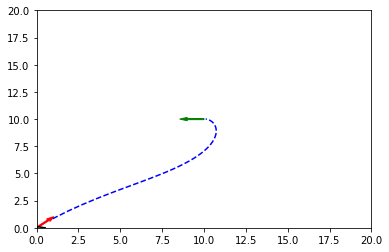

In [14]:
while(abs(true_rover_pose.x-goal_rover_pose.x)>0.1 or abs(true_rover_pose.y-goal_rover_pose.y)>0.1):

    x_pos.append(true_rover_pose.x)
    y_pos.append(true_rover_pose.y)
    [v,w] = pose_control.move_to_pose_step(true_rover_pose, goal_rover_pose)
    update(true_rover_pose,v,w,dt)

plt.cla()
plt.arrow(start[0],start[1], np.cos(start[2]),
          np.sin(start[2]), color='r', width=0.1)
plt.arrow(end[0], end[1], np.cos(end[2]),
          np.sin(end[2]), color='g', width=0.1)
pose_control.plot_vehicle(start[0],start[1],0,x_pos,y_pos)

The next step is to integrate sampling from the sensors and ekf integration and use that as the state estimate rather than simply passing in the true state.

In [17]:
from localisationMapping import ekf

Resetting the state of the rover. 

Now we need to set up a loop that uses the EKF to repeatedly estimate the state of the rover, and then use that for rover postion estimation and therefore velocity and rotation generation. 

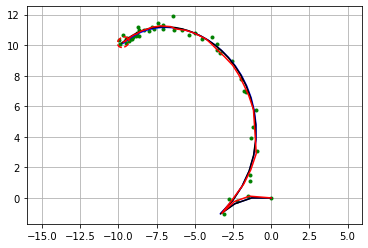

In [18]:
start= [0.0, 0.0, np.pi/4.0]
end = [-10.0, 10.0,np.pi]
v = 0 # inital velocity is zero
goal_rover_pose = Rover(end[0],end[1],end[2])
true_rover_pose = Rover(start[0],start[1],start[2])
est_rover_pose = Rover(start[0],start[1],start[2])

PEst = np.eye(4)

xDR = np.zeros((4, 1))  # Dead reckoning
state_est = np.zeros((4,1))
state_true = np.zeros((4,1))
# history
hxEst = state_est
hxTrue = state_true
hxDR = state_true
hz = np.zeros((2, 1))

error_move = abs(true_rover_pose.x-goal_rover_pose.x) + abs(true_rover_pose.y-goal_rover_pose.y)

ekf.DT = 0.01
while (error_move>0.5):
    est_rover_pose.update_state(state_est)
    true_rover_pose.update_state(state_true)

    [v,w] = pose_control.move_to_pose_step(est_rover_pose, goal_rover_pose)
    
    u = np.array([v, w])
    
    state_true, z, xDR, ud = ekf.observation(state_true, xDR, u)

    state_est, PEst = ekf.ekf_estimation(state_est, PEst, z, ud)

    # store data history
    hxEst = np.hstack((hxEst, state_est))
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, state_true))
    hz = np.hstack((hz, z))
    error_move = abs(true_rover_pose.x-goal_rover_pose.x) + abs(true_rover_pose.y-goal_rover_pose.y)
plt.cla()
plt.plot(hz[0, :], hz[1, :], ".g")
plt.plot(hxTrue[0, :].flatten(),
         hxTrue[1, :].flatten(), "-b")
plt.plot(hxDR[0, :].flatten(),
         hxDR[1, :].flatten(), "-k")
plt.plot(hxEst[0, :].flatten(),
         hxEst[1, :].flatten(), "-r")
ekf.plot_covariance_ellipse(state_est, PEst)
plt.axis("equal")
plt.grid(True)
plt.pause(0.0001)
    

One of the remaining questions is regarding the assumption behind pose control - namely that the simulation assumes that the pose of the velocity and turn rate can be perfectly controlled. This is ofcouse not even close to true, and the robustness of this algorithm needs to be evaluated in relation to that.